<a href="https://colab.research.google.com/github/fabriciocarraro/NLP-exploration_Sentiment-analysis-Disaster_prediction/blob/main/NLP_exploration_Sentiment_analysis_Disaster_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# Uninstall any existing PyTorch packages
!pip uninstall -y -q torch torchaudio torchvision

In [13]:
!pip install -q torch==2.0.1+cu118 torchvision==0.15.2+cu118 torchtext==0.15.2 -f https://download.pytorch.org/whl/torch_stable.html

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, GloVe
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from typing import Tuple
import time

In [45]:
SEED = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [15]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [16]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [17]:
train_df.isnull().sum()

,0
id,0
keyword,61
location,2533
text,0
target,0


In [18]:
train_df = train_df[['text', 'target']]
train_df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [19]:
print(train_df['target'].value_counts())

target
0    4342
1    3271
Name: count, dtype: int64


In [49]:
def bow_logistic_regression(dataset, reviews_column, classification_column):
  vectorizer = CountVectorizer(max_features=50)
  bag_of_words = vectorizer.fit_transform(dataset[reviews_column])


  X_train, X_test, y_train, y_test = train_test_split(bag_of_words,
                                                      dataset[classification_column],
                                                      random_state=SEED,
                                                      stratify=dataset[classification_column])

  model_log_reg = LogisticRegression()
  model_log_reg.fit(X_train, y_train)
  return model_log_reg.score(X_test, y_test)

print(bow_logistic_regression(train_df, 'text', 'target'))

0.6822478991596639


In [41]:
import spacy

spacy.prefer_gpu()
print("Using GPU:", spacy.prefer_gpu())

nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    text = text.lower()

    doc = nlp(text)

    cleaned_tokens = [
        token.lemma_ for token in doc
        if not token.is_punct            # Remove punctuation
        and not token.is_space           # Remove whitespaces
        and not token.is_stop            # Remove stop words
        and not token.like_url           # Remove URLs
        and not token.like_email         # Remove emails
        and token.is_alpha               # Remove non-alphabetic tokens
        and len(token.text) > 2          # Remove short words
    ]

    cleaned_text = " ".join(cleaned_tokens)
    return cleaned_text

Using GPU: True


In [71]:
treated_phrases = list()
for review in train_df['text']:
    new_phrase = preprocess_text(review)
    treated_phrases.append(new_phrase)

train_df.loc[:, 'treated_text'] = treated_phrases
train_df

,text,target,treated_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,Just got sent this photo from Ruby #Alaska as ...,1,get send photo ruby alaska smoke wildfire pour...
...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,1,giant crane hold bridge collapse nearby home
7609,@aria_ahrary @TheTawniest The out of control w...,1,control wild fire california northern state tr...
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,volcano hawaii
7611,Police investigating after an e-bike collided ...,1,police investigate bike collide car little por...


In [73]:
train_df['treated_text_length'] = train_df['treated_text'].fillna('').apply(len)
print(train_df['treated_text_length'].min())

0


In [74]:
train_df_cleaned = train_df[train_df['treated_text_length'] > 0].reset_index(drop=True)
print(train_df_cleaned['treated_text_length'].min())

3


In [75]:
print(bow_logistic_regression(train_df_cleaned, 'treated_text', 'target'))

0.695583596214511


In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_logistic_regression(dataset, reviews_column, classification_column):
    tfidf = TfidfVectorizer(max_features=50)
    tfidf_data = tfidf.fit_transform(dataset[reviews_column])

    X_train, X_test, y_train, y_test = train_test_split(tfidf_data,
                                                        dataset[classification_column],
                                                        random_state=SEED,
                                                        stratify=dataset[classification_column])

    model_log_reg = LogisticRegression()
    model_log_reg.fit(X_train, y_train)
    return model_log_reg.score(X_test, y_test)

print(tfidf_logistic_regression(train_df_cleaned, 'text', 'target'))
print(tfidf_logistic_regression(train_df_cleaned, 'treated_text', 'target'))

0.6766561514195584
0.6908517350157729


# RNN com GloVe

In [77]:
treated_train_df = train_df_cleaned[['target', 'treated_text']]
treated_train_df

,target,treated_text
0,1,deed reason earthquake allah forgive
1,1,forest fire near ronge sask canada
2,1,resident ask shelter place notify officer evac...
3,1,people receive wildfire evacuation order calif...
4,1,get send photo ruby alaska smoke wildfire pour...
...,...,...
7600,1,giant crane hold bridge collapse nearby home
7601,1,control wild fire california northern state tr...
7602,1,volcano hawaii
7603,1,police investigate bike collide car little por...


In [78]:
len(treated_train_df['treated_text'])

7605

In [79]:
spacy.prefer_gpu()
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

In [80]:
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

MAX_VOCAB_SIZE = 25_000

vocab = build_vocab_from_iterator(
    yield_tokens(treated_train_df['treated_text']),
    max_tokens=MAX_VOCAB_SIZE,
    specials=['<unk>', '<pad>']
)

vocab.set_default_index(vocab['<unk>'])

text_pipeline = lambda x: vocab(tokenizer(x))

In [81]:
def collate_batch(batch):
    label_list, text_list, lengths = [], [], []

    for (_label, _text) in batch:
        label_list.append(_label)
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        lengths.append(len(processed_text))

    return (torch.tensor(label_list, dtype=torch.int64).to(device),
            nn.utils.rnn.pad_sequence(text_list, batch_first=True).to(device),
            torch.tensor(lengths, dtype=torch.int64).to(device))

In [82]:
BATCH_SIZE = 64

X_train, X_test, y_train, y_test = train_test_split(treated_train_df['treated_text'],
                                                    treated_train_df['target'],
                                                    random_state=SEED,
                                                    stratify=treated_train_df['target'])

train_dataset = [(y, x) for x, y in zip(X_train, y_train)]
test_dataset = [(y, x) for x, y in zip(X_test, y_test)]

train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              collate_fn=collate_batch)

test_dataloader = DataLoader(test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             collate_fn=collate_batch)

In [62]:
vectors = GloVe(name='6B', dim=100)

.vector_cache/glove.6B.zip: 862MB [05:49, 2.47MB/s]                           
100%|█████████▉| 399999/400000 [00:18<00:00, 21113.41it/s]


In [90]:
class RNN_GRU(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, pad_idx):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
    self.rnn = nn.GRU(embedding_dim, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

    self.embedding.weight.data.copy_(vectors.get_vecs_by_tokens(vocab.get_itos()))
    self.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

  def forward(self, text, lengths):
    embedded = self.embedding(text)
    packed_embedded = pack_padded_sequence(embedded,
                                           lengths.cpu(),
                                           batch_first=True,
                                           enforce_sorted=False)

    packed_output, _ = self.rnn(packed_embedded)
    output, _ = pad_packed_sequence(packed_output, batch_first=True)
    output = F.adaptive_max_pool1d(output.transpose(1, 2), 1).squeeze(dim=-1)
    return self.fc(output)

In [91]:
class RNN_LSTM(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, pad_idx):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
    self.rnn = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

    self.embedding.weight.data.copy_(vectors.get_vecs_by_tokens(vocab.get_itos()))
    self.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

  def forward(self, text, lengths):
    embedded = self.embedding(text)
    packed_embedded = pack_padded_sequence(embedded,
                                           lengths.cpu(),
                                           batch_first=True,
                                           enforce_sorted=False)

    packed_output, _ = self.rnn(packed_embedded)
    output, _ = pad_packed_sequence(packed_output, batch_first=True)
    output = F.adaptive_max_pool1d(output.transpose(1, 2), 1).squeeze(dim=-1)
    return self.fc(output)

In [84]:
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = total_acc = total_count = batch_count = 0
    start = time.time()

    for labels, text, lengths in dataloader:
        optimizer.zero_grad()
        predictions = model(text, lengths)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += (predictions.argmax(dim=1) == labels).sum().item()
        total_count += labels.size(0)
        batch_count += 1

    train_loss = total_loss / batch_count
    train_acc = total_acc / total_count

    end = time.time()

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Time: {end-start:.2f}s")

    return train_loss, train_acc


def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = total_acc = total_count = batch_count = 0
    start = time.time()

    with torch.no_grad():
        for labels, text, lengths in dataloader:
            predictions = model(text, lengths)
            loss = criterion(predictions, labels)
            total_loss += loss.item()
            total_acc += (predictions.argmax(dim=1) == labels).sum().item()
            total_count += labels.size(0)
            batch_count += 1

    valid_loss = total_loss / batch_count
    valid_acc = total_acc / total_count

    end = time.time()
    print(f"Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc*100:.2f}% | Time: {end-start:.2f}s")

    return valid_loss, valid_acc

In [105]:
def run_model(model):
    N_EPOCHS = 50

    train_losses, valid_losses, train_accus, valid_accus = [], [], [], []

    for epoch in range(N_EPOCHS):
        print(f"Epoch: {epoch+1:02d}")

        train_loss, train_acc = train_epoch(model, train_dataloader, optimizer, criterion)
        valid_loss, valid_acc = evaluate(model, test_dataloader, criterion)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accus.append(train_acc)
        valid_accus.append(valid_acc)

    return N_EPOCHS, train_losses, valid_losses, train_accus, valid_accus

In [106]:
model_gru = RNN_GRU(len(vocab), 100, 256, 2, vocab['<pad>']).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model_gru.parameters(), lr=1e-4, weight_decay=5e-5)

print(model_gru)

RNN_GRU(
  (embedding): Embedding(11085, 100, padding_idx=1)
  (rnn): GRU(100, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [107]:
results_gru = []
results_gru = run_model(model_gru)

Epoch: 01
Train Loss: 0.6405 | Train Acc: 69.21% | Time: 0.69s
Valid Loss: 0.5689 | Valid Acc: 78.13% | Time: 0.14s
Epoch: 02
Train Loss: 0.5176 | Train Acc: 77.28% | Time: 0.69s
Valid Loss: 0.4775 | Valid Acc: 79.18% | Time: 0.13s
Epoch: 03
Train Loss: 0.4766 | Train Acc: 78.89% | Time: 0.70s
Valid Loss: 0.4590 | Valid Acc: 79.97% | Time: 0.13s
Epoch: 04
Train Loss: 0.4545 | Train Acc: 79.99% | Time: 0.68s
Valid Loss: 0.4472 | Valid Acc: 79.97% | Time: 0.13s
Epoch: 05
Train Loss: 0.4408 | Train Acc: 80.66% | Time: 0.68s
Valid Loss: 0.4411 | Valid Acc: 80.70% | Time: 0.13s
Epoch: 06
Train Loss: 0.4344 | Train Acc: 81.10% | Time: 0.68s
Valid Loss: 0.4366 | Valid Acc: 80.28% | Time: 0.13s
Epoch: 07
Train Loss: 0.4258 | Train Acc: 81.31% | Time: 0.68s
Valid Loss: 0.4386 | Valid Acc: 79.92% | Time: 0.13s
Epoch: 08
Train Loss: 0.4108 | Train Acc: 82.10% | Time: 0.68s
Valid Loss: 0.4319 | Valid Acc: 80.60% | Time: 0.13s
Epoch: 09
Train Loss: 0.4052 | Train Acc: 82.69% | Time: 0.70s
Valid Los

In [126]:
model_lstm = RNN_LSTM(len(vocab), 100, 256, 2, vocab['<pad>']).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model_lstm.parameters(), lr=1e-4, weight_decay=5e-5)

print(model_lstm)

RNN_LSTM(
  (embedding): Embedding(11085, 100, padding_idx=1)
  (rnn): LSTM(100, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [127]:
results_lstm = []
results_lstm = run_model(model_lstm)

Epoch: 01
Train Loss: 0.6566 | Train Acc: 68.60% | Time: 0.72s
Valid Loss: 0.5937 | Valid Acc: 75.76% | Time: 0.13s
Epoch: 02
Train Loss: 0.5293 | Train Acc: 76.61% | Time: 0.71s
Valid Loss: 0.4941 | Valid Acc: 78.34% | Time: 0.14s
Epoch: 03
Train Loss: 0.4850 | Train Acc: 78.59% | Time: 0.70s
Valid Loss: 0.4707 | Valid Acc: 79.18% | Time: 0.13s
Epoch: 04
Train Loss: 0.4671 | Train Acc: 79.68% | Time: 0.70s
Valid Loss: 0.4539 | Valid Acc: 79.50% | Time: 0.14s
Epoch: 05
Train Loss: 0.4464 | Train Acc: 80.64% | Time: 0.70s
Valid Loss: 0.4443 | Valid Acc: 79.86% | Time: 0.13s
Epoch: 06
Train Loss: 0.4340 | Train Acc: 81.06% | Time: 0.70s
Valid Loss: 0.4410 | Valid Acc: 80.70% | Time: 0.13s
Epoch: 07
Train Loss: 0.4211 | Train Acc: 81.80% | Time: 0.70s
Valid Loss: 0.4442 | Valid Acc: 80.65% | Time: 0.13s
Epoch: 08
Train Loss: 0.4105 | Train Acc: 82.64% | Time: 0.70s
Valid Loss: 0.4328 | Valid Acc: 80.39% | Time: 0.13s
Epoch: 09
Train Loss: 0.3988 | Train Acc: 83.03% | Time: 0.69s
Valid Los

In [124]:
def plot_curves(N_EPOCHS, train_losses, valid_losses, train_accus, valid_accus):
    # Plot Loss Curves
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Test Loss')
    plt.xticks(range(0, N_EPOCHS, 5))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot Accuracy Curves
    plt.figure(figsize=(8,5))
    plt.plot(train_accus, label='Train Accuracy')
    plt.plot(valid_accus, label='Test Accuracy')
    plt.xticks(range(0, N_EPOCHS, 5))
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda val, pos: f"{val * 100:.0f}%"))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

RNN - GRU


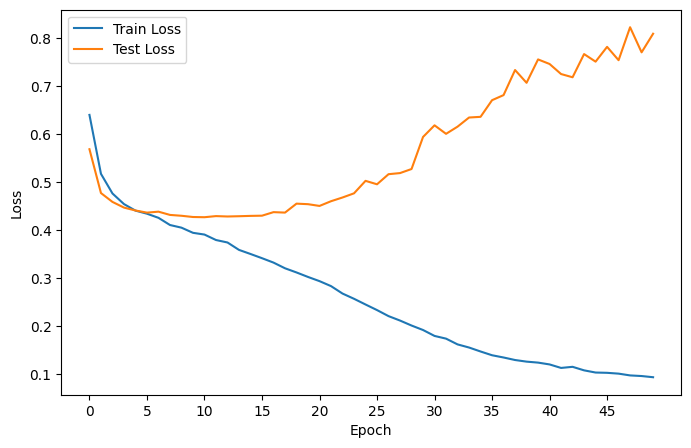

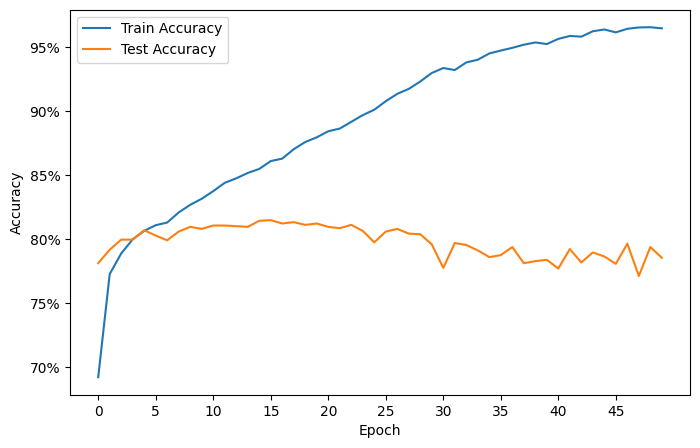

---------------------------------------------
---------------------------------------------
---------------------------------------------
RNN - LSTM


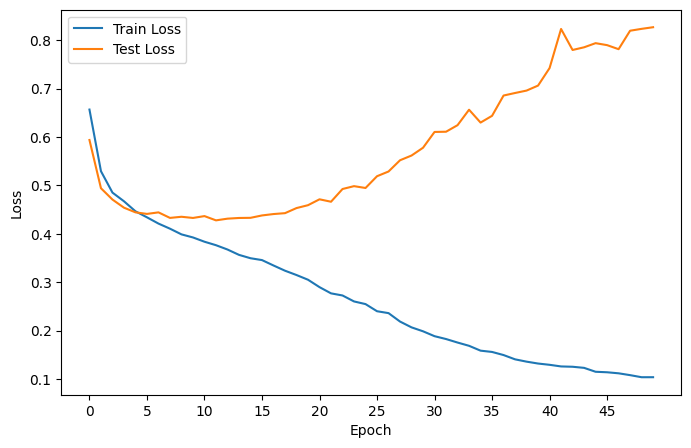

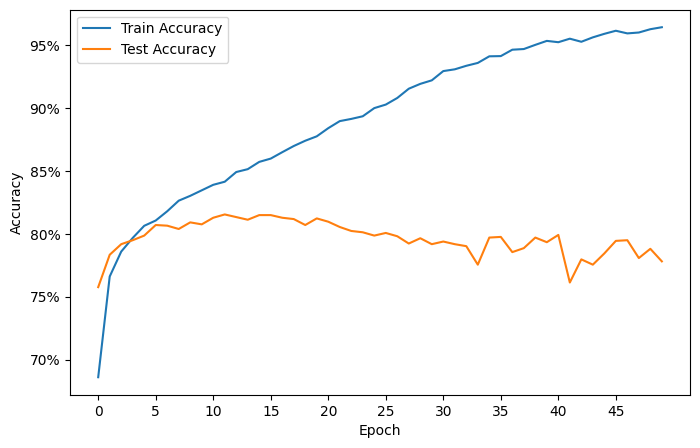

In [129]:
print('RNN - GRU')
plot_curves(results_gru[0], results_gru[1], results_gru[2], results_gru[3], results_gru[4])
print('---------'*5)
print('---------'*5)
print('---------'*5)
print('RNN - LSTM')
plot_curves(results_lstm[0], results_lstm[1], results_lstm[2], results_lstm[3], results_lstm[4])

# RoBERTa & DistilBERT

In [146]:
from transformers import (
    RobertaTokenizer, RobertaModel,
    DistilBertTokenizer, DistilBertModel,
    AdamW, get_linear_schedule_with_warmup
)
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

In [147]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [139]:
class TransformerClassifier(nn.Module):
    def __init__(self, transformer_model, n_classes):
        super().__init__()
        self.transformer = transformer_model
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.transformer.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.transformer(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.last_hidden_state[:, 0, :]  # Use [CLS] token
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

In [157]:
def train_model(model, train_loader, val_loader, device, num_epochs=3):
    optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

    # Calculate total training steps for scheduler
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    criterion = nn.CrossEntropyLoss()
    best_accuracy = 0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch + 1}/{num_epochs}')

        # Training phase
        model.train()
        total_train_loss = 0
        train_correct = 0
        train_total = 0

        for batch in tqdm(train_loader, desc='Training'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            total_train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_accuracy = 100 * train_correct / train_total

        # Validation phase
        model.eval()
        total_val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc='Validation'):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)

                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = 100 * val_correct / val_total

        print(f'Training Loss: {total_train_loss/len(train_loader):.4f}')
        print(f'Training Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Loss: {total_val_loss/len(val_loader):.4f}')
        print(f'Validation Accuracy: {val_accuracy:.2f}%')

In [149]:
def setup_roberta(train_df, batch_size=16):
    # Initialize tokenizer and model
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    transformer = RobertaModel.from_pretrained('roberta-base')

    # Split data
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_df['treated_text'].values,
        train_df['target'].values,
        test_size=0.2,
        random_state=SEED
    )

    # Create datasets
    train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer)
    val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize model
    model = TransformerClassifier(transformer, n_classes=2)

    return model, train_loader, val_loader

In [158]:
def train_roberta(train_df):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Setup model and data
    model, train_loader, val_loader = setup_roberta(train_df)
    model = model.to(device)

    # Train the model
    train_model(model, train_loader, val_loader, device, num_epochs=10)

In [159]:
train_roberta(treated_train_df)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/10


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Training Loss: 0.5195
Training Accuracy: 76.25%
Validation Loss: 0.4047
Validation Accuracy: 82.12%

Epoch 2/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Training Loss: 0.4074
Training Accuracy: 83.79%
Validation Loss: 0.4173
Validation Accuracy: 83.23%

Epoch 3/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Training Loss: 0.3414
Training Accuracy: 87.00%
Validation Loss: 0.4558
Validation Accuracy: 82.58%

Epoch 4/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Training Loss: 0.2821
Training Accuracy: 89.94%
Validation Loss: 0.6068
Validation Accuracy: 81.33%

Epoch 5/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Training Loss: 0.2307
Training Accuracy: 91.85%
Validation Loss: 0.6345
Validation Accuracy: 81.79%

Epoch 6/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Training Loss: 0.1979
Training Accuracy: 93.61%
Validation Loss: 0.7912
Validation Accuracy: 80.60%

Epoch 7/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Training Loss: 0.1711
Training Accuracy: 94.64%
Validation Loss: 0.9194
Validation Accuracy: 81.46%

Epoch 8/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Training Loss: 0.1613
Training Accuracy: 95.07%
Validation Loss: 0.9956
Validation Accuracy: 79.82%

Epoch 9/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Training Loss: 0.1262
Training Accuracy: 96.33%
Validation Loss: 1.1605
Validation Accuracy: 80.14%

Epoch 10/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Training Loss: 0.1115
Training Accuracy: 96.75%
Validation Loss: 1.1477
Validation Accuracy: 80.41%


In [152]:
def setup_distilbert(train_df, batch_size=16):
    # Initialize tokenizer and model
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    transformer = DistilBertModel.from_pretrained('distilbert-base-uncased')

    # Split data
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_df['treated_text'].values,
        train_df['target'].values,
        test_size=0.2,
        random_state=SEED
    )

    # Create datasets
    train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer)
    val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize model
    model = TransformerClassifier(transformer, n_classes=2)

    return model, train_loader, val_loader

In [161]:
def train_distilbert(train_df):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Setup model and data
    model, train_loader, val_loader = setup_distilbert(train_df)
    model = model.to(device)

    # Train the model
    train_model(model, train_loader, val_loader, device, num_epochs=10)

In [162]:
train_distilbert(treated_train_df)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Training Loss: 0.4746
Training Accuracy: 78.98%
Validation Loss: 0.4121
Validation Accuracy: 83.23%

Epoch 2/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Training Loss: 0.3641
Training Accuracy: 84.99%
Validation Loss: 0.4140
Validation Accuracy: 83.63%

Epoch 3/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Training Loss: 0.2720
Training Accuracy: 89.58%
Validation Loss: 0.5681
Validation Accuracy: 79.36%

Epoch 4/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Training Loss: 0.2078
Training Accuracy: 93.11%
Validation Loss: 0.6242
Validation Accuracy: 79.49%

Epoch 5/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Training Loss: 0.1540
Training Accuracy: 94.86%
Validation Loss: 0.7901
Validation Accuracy: 79.82%

Epoch 6/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Training Loss: 0.1281
Training Accuracy: 95.83%
Validation Loss: 0.8808
Validation Accuracy: 80.67%

Epoch 7/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Training Loss: 0.0960
Training Accuracy: 96.73%
Validation Loss: 1.0747
Validation Accuracy: 79.62%

Epoch 8/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Training Loss: 0.0856
Training Accuracy: 97.11%
Validation Loss: 1.0713
Validation Accuracy: 80.67%

Epoch 9/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Training Loss: 0.0703
Training Accuracy: 97.58%
Validation Loss: 1.1238
Validation Accuracy: 81.07%

Epoch 10/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Training Loss: 0.0627
Training Accuracy: 97.81%
Validation Loss: 1.1694
Validation Accuracy: 80.41%
